<a href="https://colab.research.google.com/github/vvshankar78/EVA4.0-Assignment-6/blob/master/EVA4_Assign6b_L1Norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


CUDA Available? True


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


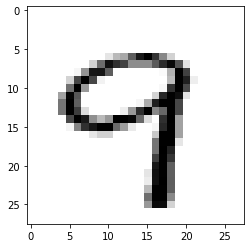

In [6]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

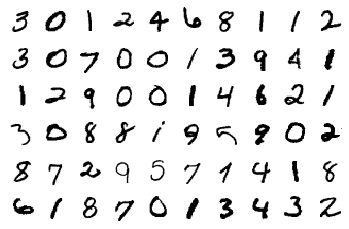

In [7]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# The model
Let's start with the model we first saw

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 22
        

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU() 
        ) # output_size = 5

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU() 
        ) # output_size = 3

        # TRANSITION BLOCK 2
        #self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 5

        # self.convblock11 = nn.Sequential(
        #     nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3,3), padding=0, bias=False),
        #     #nn.ReLU() 
        # ) # output_size = 1

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        )
    

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        #x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.gap(x)
        #x = self.convblock11(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 16, 22, 22]           1,440
       BatchNorm2d-8           [-1, 16, 22, 22]              32
              ReLU-9           [-1, 16, 22, 22]               0
        MaxPool2d-10           [-1, 16, 11, 11]               0
           Conv2d-11           [-1, 10, 11, 11]             160
      BatchNorm2d-12           [-1, 10, 11, 11]              20
             ReLU-13           [-1, 10, 11, 11]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []                     
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # calculate Regularization
    wd = 1e-4  
    #L1 Loss
    w1 = 0.
    for p in model.parameters(): w1 += torch.sum(abs(p)) 

    # L2 Loss
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()

    # # Rohan's code
    # w3 = 0.
    # l1_crit = nn.L1Loss(reduce=False)
    # for p in model.parameters(): w3+=l1_crit(p)


    # Calculate loss
    loss = F.nll_loss(y_pred, target) + (w1*wd)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [11]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.15274298191070557 Batch_id=468 Accuracy=93.71: 100%|██████████| 469/469 [00:24<00:00, 24.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0826, Accuracy: 9849/10000 (98.49%)

EPOCH: 1


Loss=0.11969481408596039 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:24<00:00, 19.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0588, Accuracy: 9874/10000 (98.74%)

EPOCH: 2


Loss=0.14840078353881836 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:23<00:00, 19.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0409, Accuracy: 9900/10000 (99.00%)

EPOCH: 3


Loss=0.09783055633306503 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:23<00:00, 25.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Accuracy: 9899/10000 (98.99%)

EPOCH: 4


Loss=0.13537193834781647 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:23<00:00, 19.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0394, Accuracy: 9901/10000 (99.01%)

EPOCH: 5


Loss=0.10294562578201294 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:23<00:00, 19.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0377, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Loss=0.0884750485420227 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:23<00:00, 23.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0439, Accuracy: 9875/10000 (98.75%)

EPOCH: 7


Loss=0.17910368740558624 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:24<00:00, 19.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0411, Accuracy: 9892/10000 (98.92%)

EPOCH: 8


Loss=0.0628788098692894 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:24<00:00, 26.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9907/10000 (99.07%)

EPOCH: 9


Loss=0.08416576683521271 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:24<00:00, 19.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9911/10000 (99.11%)

EPOCH: 10


Loss=0.06804176419973373 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:23<00:00, 19.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9912/10000 (99.12%)

EPOCH: 11


Loss=0.08960095047950745 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:23<00:00, 19.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9924/10000 (99.24%)

EPOCH: 12


Loss=0.07979879528284073 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:23<00:00, 19.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.05671142414212227 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:23<00:00, 19.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9932/10000 (99.32%)

EPOCH: 14


Loss=0.08988501131534576 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:23<00:00, 19.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9912/10000 (99.12%)

EPOCH: 15


Loss=0.05649231746792793 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:23<00:00, 19.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0300, Accuracy: 9919/10000 (99.19%)

EPOCH: 16


Loss=0.10316920280456543 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:23<00:00, 19.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9935/10000 (99.35%)

EPOCH: 17


Loss=0.08730030804872513 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:24<00:00, 19.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0246, Accuracy: 9936/10000 (99.36%)

EPOCH: 18


Loss=0.090663380920887 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:24<00:00, 19.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9927/10000 (99.27%)

EPOCH: 19


Loss=0.04865638539195061 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:23<00:00, 23.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9942/10000 (99.42%)

EPOCH: 20


Loss=0.04892054572701454 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:24<00:00, 24.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9937/10000 (99.37%)

EPOCH: 21


Loss=0.11944431066513062 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:24<00:00, 19.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9924/10000 (99.24%)

EPOCH: 22


Loss=0.04913182556629181 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:24<00:00, 23.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9926/10000 (99.26%)

EPOCH: 23


Loss=0.07608003169298172 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:24<00:00, 19.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9915/10000 (99.15%)

EPOCH: 24


Loss=0.06029800325632095 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:23<00:00, 24.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9936/10000 (99.36%)

EPOCH: 25


Loss=0.04724472388625145 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:24<00:00, 19.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9923/10000 (99.23%)

EPOCH: 26


Loss=0.0672941729426384 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:24<00:00, 24.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0268, Accuracy: 9930/10000 (99.30%)

EPOCH: 27


Loss=0.048545267432928085 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:24<00:00, 23.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9925/10000 (99.25%)

EPOCH: 28


Loss=0.06100066751241684 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:25<00:00, 18.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9935/10000 (99.35%)

EPOCH: 29


Loss=0.076667919754982 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:25<00:00, 18.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9910/10000 (99.10%)

EPOCH: 30


Loss=0.11760938167572021 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:25<00:00, 22.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9909/10000 (99.09%)

EPOCH: 31


Loss=0.05688690394163132 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:24<00:00, 18.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9918/10000 (99.18%)

EPOCH: 32


Loss=0.0782172679901123 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:25<00:00, 18.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9935/10000 (99.35%)

EPOCH: 33


Loss=0.055632125586271286 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:25<00:00, 18.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9924/10000 (99.24%)

EPOCH: 34


Loss=0.05223867669701576 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:24<00:00, 19.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9927/10000 (99.27%)

EPOCH: 35


Loss=0.051896724849939346 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:24<00:00, 19.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9932/10000 (99.32%)

EPOCH: 36


Loss=0.061702899634838104 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:23<00:00, 19.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9937/10000 (99.37%)

EPOCH: 37


Loss=0.05170489847660065 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:23<00:00, 20.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9918/10000 (99.18%)

EPOCH: 38


Loss=0.061197444796562195 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:22<00:00, 20.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9921/10000 (99.21%)

EPOCH: 39


Loss=0.05100198835134506 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:22<00:00, 20.47it/s]



Test set: Average loss: 0.0299, Accuracy: 9912/10000 (99.12%)



Text(0.5, 1.0, 'Test Accuracy')

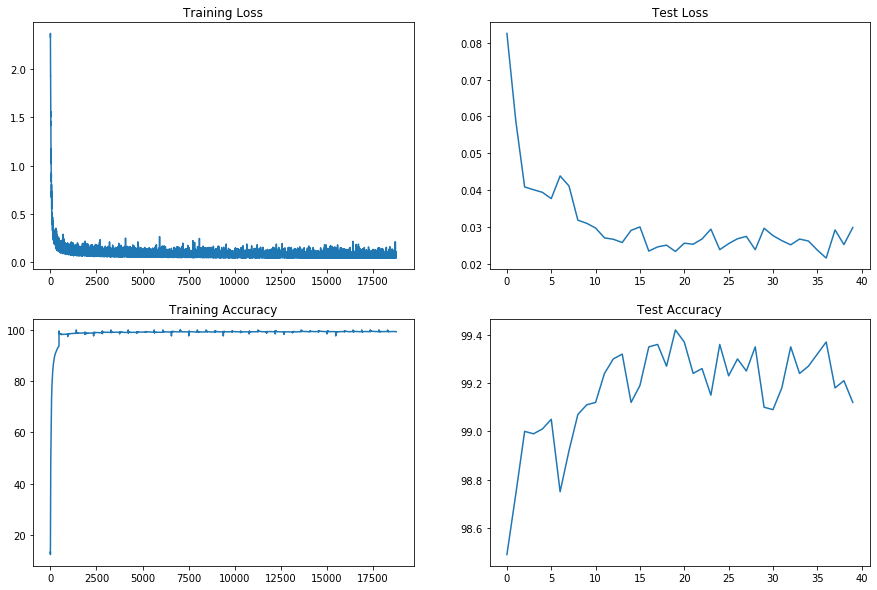

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [0]:
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=10000, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)


# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

In [14]:
model.eval();

correct = 0
with torch.no_grad():
  for data,target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = (output.argmax(dim=1, keepdim=True)).cpu()
    print(data.shape)
    print(output.shape)
    print(target.shape)
    



torch.Size([10000, 1, 28, 28])
torch.Size([10000, 10])
torch.Size([10000])


# of misclassified images :  88


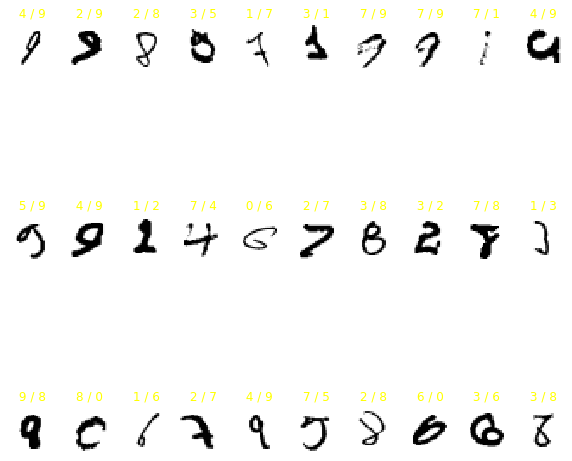

In [15]:

pred_ic = pred.cpu().numpy()
target_ic = target.view_as(pred).cpu().numpy()
data_ic =  data.cpu().numpy()

#print(pred_ic.shape, target_ic.shape, data_ic.shape)

test_incorrect = []
for i in range(10000):
  if pred_ic[i] != target_ic[i]:
    test_incorrect.append(i)

#print(test_incorrect[0:5])
print("# of misclassified images : ", len(test_incorrect))

figure = plt.figure(figsize=(10,10))
num_of_images = 30
for index in range(1, num_of_images+1):
  plt.subplot(3,10,index)
  plt.axis('off')
  plt.title(" %d / %d" % (pred_ic[test_incorrect[index]],target_ic[test_incorrect[index]]), color='yellow')
  plt.imshow(data_ic[test_incorrect[index]].squeeze(),cmap='gray_r')
